In [1]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('SAVE_EOM.db')

'''Lambdify the EOM'''

func_map = {'sin':sin, 'cos':cos} 

sym_list = [[g,
             m_boom,m_body,m_foot,
             m_ull, m_lll,
             m_url, m_lrl,
             l_body, LL, l_foot,
             l_ull, l_lll,
             l_url, l_lrl,
             In_body,In_foot,
             In_ull, In_lll,
             In_url, In_lrl,
             x_body, y_body,th_body,
             th_ull, th_lll,
             th_url, th_lrl,
             dx_body, dy_body,dth_body,
             dth_ull, dth_lll,
             dth_url, dth_lrl,
             ddx_body, ddy_body,ddth_body,
             ddth_ull, ddth_lll,
             ddth_url, ddth_lrl,
             tau_left,tau_right,
             lamda_x,lamda_y,
             GRF_x, GRF_y]]

lambEOM_x_body = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y_body = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_th_body = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_th_ull = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_th_lll = sym.lambdify(sym_list,EOMs[4],modules = [func_map])
lambEOM_th_url = sym.lambdify(sym_list,EOMs[5],modules = [func_map])
lambEOM_th_lrl = sym.lambdify(sym_list,EOMs[6],modules = [func_map])

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


In [2]:
''' SET '''
# deletes the m model existing in the workspace
if 'm' in globals():
    del m 
    
m = ConcreteModel('Monopod')

N = 100 # nodes
TT = 0.2 #2.1 # seconds

# HOP
# N = 20 # nodes
# TT = 0.5 # seconds



# N = 100 # nodes
# HDT and LDT (N = 50 TT = 0.2)
# Hop (N = 50 TT = 2.5)


m.N = RangeSet(N)

links = ['body','ull','lll','url','lrl']
m.L = Set(dimen=1, initialize = links) # set of links
DOFs = ['xb','yb','thb','thull','thlll','thurl','thlrl'] 
m.DOF = Set(initialize = DOFs) # set of degrees of freedom

In [3]:
''' PARAMETERS '''
m.g = Param(initialize = 9.81)
m.LL = Param(initialize = 7.5/100)
m.mass_boom = Param(initialize = 1.806)

m.length_foot = Param(initialize = 4.5/100)
m.mass_foot = Param(initialize = 0.07)
m.In_foot = Param(initialize = (m.mass_foot.value*m.length_foot.value**2)/12 )


def get_mass(n, lb):
    if lb == 'body':
        return 2.06 
    elif lb == 'ull' or lb == 'url':
        return 0.31
    elif lb == 'lll' or lb =='lrl':
        return 0.53
    else: pass
m.mass = Param(m.L, initialize = get_mass) # mass of links

def get_length(n, lb):
    if lb == 'body':
        return 24/100 # 15.0/100
    elif lb == 'ull' or lb == 'url':
        return 17.5/100
    elif lb == 'lll' or lb == 'lrl':
        return 30.0/100
    else: pass
m.length = Param(m.L, initialize = get_length) # length of links

def calculate_In(m, lb):
    return (m.mass[lb]*m.length[lb]**2)/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

# def calculate_In(m, lb):
#     if lb == 'body':
#         return 4076235.85/(1000*1000**2)
#     elif lb == 'lll' or lb == 'lrl':
#         return 9382285.15/(1000*1000**2)
#     elif lb == 'ull' or lb == 'url':
#         return 5419395.39/(1000*1000**2)
# m.In = Param(m.L, initialize = calculate_In) # moment of inertia


# For scaling
mbody_tot = m.mass_foot.value + m.mass_boom.value 

for link_add in links:
    mbody_tot = mbody_tot + m.mass[link_add]
    
BW = mbody_tot*m.g.value

# BW = 1

# mbody = sum(m.mass[l] for l in links)
# BW = mbody*m.g.value

In [4]:
# print(/(1000*1000**2))
# print(m.In['ull'])
# print(m.In['lll'])
# print(m.In_foot.value)

In [5]:
mbody = sum(m.mass[l] for l in links)
print(mbody)

3.74


In [6]:
''' Variables '''

m.X = Var(m.N, m.DOF)
m.dX = Var(m.N, m.DOF)
m.ddX = Var(m.N, m.DOF)

# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

In [7]:
''' CONSTRAINTS  - Integration'''
 
def BwEuler_p(m,n,dof):
    if n > 1:
        return m.X[n,dof] == m.X[n-1,dof] + hm*m.h[n]*m.dX[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dX[n,dof] == m.dX[n-1,dof] + hm*m.h[n]*m.ddX[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

In [8]:
signs = ['-ve','+ve'] 
m.sign = Set(initialize = signs) # we do this to avoid using negative values 

WDOFs = ['X','Y']
m.WDOF = Set(initialize = WDOFs) # this is for the connect only (remember that DOF is in terms of the q but the connect containt force has X and Y coordinates)

# Variable of boom position
m.boom_position = Var(m.N, m.WDOF)

# Get the boom position in WDOF
boom_position_x = r_boom[0].simplify()
boom_position_y = r_boom[1].simplify()

lamb_boom_position_x = sym.lambdify(sym_list,boom_position_x,modules = [func_map])
lamb_boom_position_y = sym.lambdify(sym_list,boom_position_y,modules = [func_map])

def def_boom_position_y(m,n,dof):
    if dof == 'Y':
        var_list = [[m.g,
                    m.mass_boom, m.mass['body'], m.mass_foot,
                    m.mass['ull'], m.mass['lll'],
                    m.mass['url'], m.mass['lrl'],
                    m.length['body'], m.LL, m.length_foot,
                    m.length['ull'], m.length['lll'],
                    m.length['url'], m.length['lrl'],
                    m.In['body'], m.In_foot,
                    m.In['ull'], m.In['lll'],
                    m.In['url'], m.In['lrl'],
                    m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                    m.X[n,'thull'],m.X[n,'thlll'],
                    m.X[n,'thurl'],m.X[n,'thlrl'],
                    m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                    m.dX[n,'thull'],  m.dX[n,'thlll'],
                    m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                    m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                    m.ddX[n,'thull'], m.ddX[n,'thlll'],
                    m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                    0,0,
                    0,0,
                    0,0]]
        return m.boom_position[n,'Y'] == lamb_boom_position_y(*var_list)
    else: return Constraint.Skip
m.def_boom_position_y = Constraint(m.N, m.WDOF, rule = def_boom_position_y)

def def_boom_position_x(m,n,dof):
    if dof == 'X':
        var_list =[[m.g,
                    m.mass_boom, m.mass['body'], m.mass_foot,
                    m.mass['ull'], m.mass['lll'],
                    m.mass['url'], m.mass['lrl'],
                    m.length['body'], m.LL, m.length_foot,
                    m.length['ull'], m.length['lll'],
                    m.length['url'], m.length['lrl'],
                    m.In['body'], m.In_foot,
                    m.In['ull'], m.In['lll'],
                    m.In['url'], m.In['lrl'],
                    m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                    m.X[n,'thull'],m.X[n,'thlll'],
                    m.X[n,'thurl'],m.X[n,'thlrl'],
                    m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                    m.dX[n,'thull'],  m.dX[n,'thlll'],
                    m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                    m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                    m.ddX[n,'thull'], m.ddX[n,'thlll'],
                    m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                    0,0,
                    0,0,
                    0,0]]
        return m.boom_position[n,'X'] == lamb_boom_position_x(*var_list)
    else: return Constraint.Skip
m.def_boom_position_x = Constraint(m.N, m.WDOF, rule = def_boom_position_x)


In [9]:
''' CONSTRAINTS  - CONNECTION POINT'''

m.lamda_y = Var(m.N, m.sign, bounds = (0.0,None)) # connection force
m.lamda_x = Var(m.N, m.sign, bounds = (0.0,None)) # connection force

# Set connection variables of both left and right links
m.connect_position_left = Var(m.N, m.WDOF)
m.connect_position_right = Var(m.N, m.WDOF)

# Get the connect position in WDOF from the previous script
connect_position_left_x = connect_position_left[0].simplify()
connect_position_left_y = connect_position_left[1].simplify()

connect_position_right_x = connect_position_right[0].simplify()
connect_position_right_y = connect_position_right[1].simplify()

# Lamdify
lamb_connect_position_left_x = sym.lambdify(sym_list,connect_position_left_x,modules = [func_map])
lamb_connect_position_left_y = sym.lambdify(sym_list,connect_position_left_y,modules = [func_map])

lamb_connect_position_right_x = sym.lambdify(sym_list,connect_position_right_x,modules = [func_map])
lamb_connect_position_right_y = sym.lambdify(sym_list,connect_position_right_y,modules = [func_map])

# Equate the connection equations from the previous script to the model m
def def_connect_position_left_y(m,n,dof):
    if dof == 'Y':
        var_list =[[m.g,
                    m.mass_boom, m.mass['body'], m.mass_foot,
                    m.mass['ull'], m.mass['lll'],
                    m.mass['url'], m.mass['lrl'],
                    m.length['body'], m.LL, m.length_foot,
                    m.length['ull'], m.length['lll'],
                    m.length['url'], m.length['lrl'],
                    m.In['body'], m.In_foot,
                    m.In['ull'], m.In['lll'],
                    m.In['url'], m.In['lrl'],
                    m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                    m.X[n,'thull'],m.X[n,'thlll'],
                    m.X[n,'thurl'],m.X[n,'thlrl'],
                    m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                    m.dX[n,'thull'],  m.dX[n,'thlll'],
                    m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                    m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                    m.ddX[n,'thull'], m.ddX[n,'thlll'],
                    m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                    0,0,
                    0,0,
                    0,0]]
        return m.connect_position_left[n,'Y'] == lamb_connect_position_left_y(*var_list)
    else: return Constraint.Skip
m.def_connect_position_left_y = Constraint(m.N, m.WDOF, rule = def_connect_position_left_y)

def def_connect_position_left_x(m,n,dof):
    if dof == 'X':
        var_list =[[m.g,
                    m.mass_boom, m.mass['body'], m.mass_foot,
                    m.mass['ull'], m.mass['lll'],
                    m.mass['url'], m.mass['lrl'],
                    m.length['body'], m.LL, m.length_foot,
                    m.length['ull'], m.length['lll'],
                    m.length['url'], m.length['lrl'],
                    m.In['body'], m.In_foot,
                    m.In['ull'], m.In['lll'],
                    m.In['url'], m.In['lrl'],
                    m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                    m.X[n,'thull'],m.X[n,'thlll'],
                    m.X[n,'thurl'],m.X[n,'thlrl'],
                    m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                    m.dX[n,'thull'],  m.dX[n,'thlll'],
                    m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                    m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                    m.ddX[n,'thull'], m.ddX[n,'thlll'],
                    m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                    0,0,
                    0,0,
                    0,0]]
        return m.connect_position_left[n,'X'] == lamb_connect_position_left_x(*var_list)
    else: return Constraint.Skip
m.def_connect_position_left_x = Constraint(m.N, m.WDOF, rule = def_connect_position_left_x)

def def_connect_position_right_y(m,n,dof):
    if dof == 'Y':
        var_list =[[m.g,
                    m.mass_boom, m.mass['body'], m.mass_foot,
                    m.mass['ull'], m.mass['lll'],
                    m.mass['url'], m.mass['lrl'],
                    m.length['body'], m.LL, m.length_foot,
                    m.length['ull'], m.length['lll'],
                    m.length['url'], m.length['lrl'],
                    m.In['body'], m.In_foot,
                    m.In['ull'], m.In['lll'],
                    m.In['url'], m.In['lrl'],
                    m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                    m.X[n,'thull'],m.X[n,'thlll'],
                    m.X[n,'thurl'],m.X[n,'thlrl'],
                    m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                    m.dX[n,'thull'],  m.dX[n,'thlll'],
                    m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                    m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                    m.ddX[n,'thull'], m.ddX[n,'thlll'],
                    m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                    0,0,
                    0,0,
                    0,0]]
        return m.connect_position_right[n,'Y'] == lamb_connect_position_right_y(*var_list)
    else: return Constraint.Skip
m.def_connect_position_right_y = Constraint(m.N, m.WDOF, rule = def_connect_position_right_y)

def def_connect_position_right_x(m,n,dof):
    if dof == 'X':
        var_list =[[m.g,
                    m.mass_boom, m.mass['body'], m.mass_foot,
                    m.mass['ull'], m.mass['lll'],
                    m.mass['url'], m.mass['lrl'],
                    m.length['body'], m.LL, m.length_foot,
                    m.length['ull'], m.length['lll'],
                    m.length['url'], m.length['lrl'],
                    m.In['body'], m.In_foot,
                    m.In['ull'], m.In['lll'],
                    m.In['url'], m.In['lrl'],
                    m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                    m.X[n,'thull'],m.X[n,'thlll'],
                    m.X[n,'thurl'],m.X[n,'thlrl'],
                    m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                    m.dX[n,'thull'],  m.dX[n,'thlll'],
                    m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                    m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                    m.ddX[n,'thull'], m.ddX[n,'thlll'],
                    m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                    0,0,
                    0,0,
                    0,0]]
        return m.connect_position_right[n,'X'] == lamb_connect_position_right_x(*var_list)
    else: return Constraint.Skip
m.def_connect_position_right_x = Constraint(m.N, m.WDOF, rule = def_connect_position_right_x)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_x(m,n):
    return  m.connect_position_right[n,'X'] - m.connect_position_left[n,'X'] == 0.0
m.connect_x = Constraint(m.N, rule = def_connect_x)

def def_connect_y(m,n):
    return m.connect_position_right[n,'Y'] - m.connect_position_left[n,'Y'] == 0.0
m.connect_y_constraint = Constraint(m.N, rule = def_connect_y)

In [10]:
# Variable of foot position
m.foot_position = Var(m.N, m.WDOF,bounds = (0.0,None))

# Get the foot position in WDOF
foot_position_x = foot_position[0].simplify()
foot_position_y = foot_position[1].simplify()

lamb_foot_position_x = sym.lambdify(sym_list,foot_position_x,modules = [func_map])
lamb_foot_position_y = sym.lambdify(sym_list,foot_position_y,modules = [func_map])

def def_foot_position_y(m,n,dof):
    if dof == 'Y':
        var_list =[[m.g,
                    m.mass_boom, m.mass['body'], m.mass_foot,
                    m.mass['ull'], m.mass['lll'],
                    m.mass['url'], m.mass['lrl'],
                    m.length['body'], m.LL, m.length_foot,
                    m.length['ull'], m.length['lll'],
                    m.length['url'], m.length['lrl'],
                    m.In['body'], m.In_foot,
                    m.In['ull'], m.In['lll'],
                    m.In['url'], m.In['lrl'],
                    m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                    m.X[n,'thull'],m.X[n,'thlll'],
                    m.X[n,'thurl'],m.X[n,'thlrl'],
                    m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                    m.dX[n,'thull'],  m.dX[n,'thlll'],
                    m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                    m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                    m.ddX[n,'thull'], m.ddX[n,'thlll'],
                    m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                    0,0,
                    0,0,
                    0,0]]
        return m.foot_position[n,'Y'] == lamb_foot_position_y(*var_list)
    else: return Constraint.Skip
m.def_foot_position_y = Constraint(m.N, m.WDOF, rule = def_foot_position_y)

def def_foot_position_x(m,n,dof):
    if dof == 'X':
        var_list =[[m.g,
                    m.mass_boom, m.mass['body'], m.mass_foot,
                    m.mass['ull'], m.mass['lll'],
                    m.mass['url'], m.mass['lrl'],
                    m.length['body'], m.LL, m.length_foot,
                    m.length['ull'], m.length['lll'],
                    m.length['url'], m.length['lrl'],
                    m.In['body'], m.In_foot,
                    m.In['ull'], m.In['lll'],
                    m.In['url'], m.In['lrl'],
                    m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                    m.X[n,'thull'],m.X[n,'thlll'],
                    m.X[n,'thurl'],m.X[n,'thlrl'],
                    m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                    m.dX[n,'thull'],  m.dX[n,'thlll'],
                    m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                    m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                    m.ddX[n,'thull'], m.ddX[n,'thlll'],
                    m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                    0,0,
                    0,0,
                    0,0]]
        return m.foot_position[n,'X'] == lamb_foot_position_x(*var_list)
    else: return Constraint.Skip
m.def_foot_position_x = Constraint(m.N, m.WDOF, rule = def_foot_position_x)

In [11]:
m.mu = Param(initialize = 1,within=Any)

ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
m.ground_constraint = Set(initialize = ground_constraints)

# Variables
m.foot_velocity = Var(m.N, m.WDOF, m.sign, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, bounds = (0.0,None)) # ground reaction forces
m.GRF_x = Var(m.N, m.sign, bounds = (0.0,None)) # ground reaction forces
m.ground_penalty = Var(m.N, m.ground_constraint, bounds = (0.0,None)) # penalty

# Get the foot position in WDOF
foot_velocity = foot_position.jacobian(q)*dq # we solved the foot_position above
foot_velocity_x = foot_velocity[0].simplify()
lamb_foot_velocity_x = sym.lambdify(sym_list,foot_velocity_x,modules = [func_map])

# CONSTRAINTS
def def_foot_velocity(m,n,dof):
    if dof == 'X':
        var_list =[[m.g,
                    m.mass_boom, m.mass['body'], m.mass_foot,
                    m.mass['ull'], m.mass['lll'],
                    m.mass['url'], m.mass['lrl'],
                    m.length['body'], m.LL, m.length_foot,
                    m.length['ull'], m.length['lll'],
                    m.length['url'], m.length['lrl'],
                    m.In['body'], m.In_foot,
                    m.In['ull'], m.In['lll'],
                    m.In['url'], m.In['lrl'],
                    m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                    m.X[n,'thull'],m.X[n,'thlll'],
                    m.X[n,'thurl'],m.X[n,'thlrl'],
                    m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                    m.dX[n,'thull'],  m.dX[n,'thlll'],
                    m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                    m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                    m.ddX[n,'thull'], m.ddX[n,'thlll'],
                    m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                    0,0,
                    0,0,
                    0,0]]
        
        return m.foot_velocity[n,'X','+ve']-m.foot_velocity[n,'X','-ve'] == lamb_foot_velocity_x(*var_list)
    else: return Constraint.Skip
m.def_foot_velocity = Constraint(m.N, m.WDOF, rule = def_foot_velocity)

def def_friction_cone(m,n):
    return m.friction_cone[n] == m.mu*m.GRF_y[n] - (m.GRF_x[n,'+ve'] + m.GRF_x[n,'-ve'])
m.def_friction_cone = Constraint(m.N, rule = def_friction_cone)

# constraints: complementarity

# contact
def ground_contact(m,n):
    if n < N:
        return m.ground_penalty[n,'contact'] == m.foot_position[n+1,'Y']*m.GRF_y[n] 
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, rule = ground_contact)

# friction
def ground_friction(m,n):
    return m.ground_penalty[n,'friction'] == (m.foot_velocity[n,'X','+ve']+m.foot_velocity[n,'X','-ve'])*m.friction_cone[n]
m.ground_friction = Constraint(m.N, rule = ground_friction)

# slipping
def ground_slip_positive(m,n):
    return m.ground_penalty[n,'slip_+ve'] == m.foot_velocity[n,'X','+ve']*m.GRF_x[n,'+ve']
m.ground_slip_positive = Constraint(m.N, rule = ground_slip_positive)

def ground_slip_negative(m,n):
    return m.ground_penalty[n,'slip_-ve'] == m.foot_velocity[n,'X','-ve']*m.GRF_x[n,'-ve']
m.ground_slip_negative = Constraint(m.N, rule = ground_slip_negative)

# bound contact forces at last node
for sgn in signs:
    m.GRF_y[N].fix(0.0)
    m.GRF_x[N,sgn].fix(0.0)

Text(0, 0.5, 'Torque (Nm)')

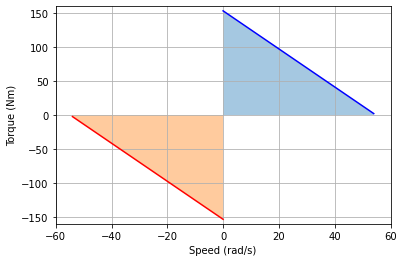

In [12]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
y_p = -2.8*x_p + 153.4
y_n = -2.8*x_n - 153.4

plt.grid()
plt.plot(x_p, y_p,'b')
plt.fill_between(x_p, y_p, alpha=0.4)

plt.plot(x_n, y_n,'r')
plt.fill_between(x_n, y_n, alpha=0.4)

plt.axis((-60,60,-160,160))
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')

In [13]:
'''Constant Power - Speed Torque Curve'''

# Left Motor

m.tau_left_actuator = Var(m.N, m.sign, bounds = (0.0,38.0))
m.left_angular_velocity = Var(m.N, m.sign, bounds = (0.0,46.0))

left_angular_velocity = w_ull # from previous script

lamb_left_angular_velocity = sym.lambdify(sym_list,left_angular_velocity,modules = [func_map])

def def_left_angular_velocity(m,n):
    var_list = [[m.g,
                    m.mass_boom, m.mass['body'], m.mass_foot,
                    m.mass['ull'], m.mass['lll'],
                    m.mass['url'], m.mass['lrl'],
                    m.length['body'], m.LL, m.length_foot,
                    m.length['ull'], m.length['lll'],
                    m.length['url'], m.length['lrl'],
                    m.In['body'], m.In_foot,
                    m.In['ull'], m.In['lll'],
                    m.In['url'], m.In['lrl'],
                    m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                    m.X[n,'thull'],m.X[n,'thlll'],
                    m.X[n,'thurl'],m.X[n,'thlrl'],
                    m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                    m.dX[n,'thull'],  m.dX[n,'thlll'],
                    m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                    m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                    m.ddX[n,'thull'], m.ddX[n,'thlll'],
                    m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                    0,0,
                    0,0,
                    0,0]]
    return m.left_angular_velocity[n,'+ve']-m.left_angular_velocity[n,'-ve'] == lamb_left_angular_velocity(*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, rule = def_left_angular_velocity)

# assume straight line
def def_constant_power_left_pos(m,n):
    return m.tau_left_actuator[n,'+ve'] <= m.left_angular_velocity[n,'+ve']*(-2.8) + 153.4
m.constant_power_left_pos = Constraint(m.N, rule = def_constant_power_left_pos)

def def_constant_power_left_neg(m,n):
    return m.tau_left_actuator[n,'-ve'] >= m.left_angular_velocity[n,'-ve']*(-2.8) - 153.4
m.constant_power_left_neg = Constraint(m.N, rule = def_constant_power_left_neg)

In [14]:
'''Constant Power - Speed Torque Curve'''

# Right Motor

m.tau_right_actuator = Var(m.N, m.sign, bounds = (0.0,38.0))
m.right_angular_velocity = Var(m.N, m.sign, bounds = (0.0,46.0)) 

right_angular_velocity = w_url 

lamb_right_angular_velocity = sym.lambdify(sym_list,right_angular_velocity,modules = [func_map])

def def_right_angular_velocity(m,n):
    var_list =[[m.g,
                    m.mass_boom, m.mass['body'], m.mass_foot,
                    m.mass['ull'], m.mass['lll'],
                    m.mass['url'], m.mass['lrl'],
                    m.length['body'], m.LL, m.length_foot,
                    m.length['ull'], m.length['lll'],
                    m.length['url'], m.length['lrl'],
                    m.In['body'], m.In_foot,
                    m.In['ull'], m.In['lll'],
                    m.In['url'], m.In['lrl'],
                    m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                    m.X[n,'thull'],m.X[n,'thlll'],
                    m.X[n,'thurl'],m.X[n,'thlrl'],
                    m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                    m.dX[n,'thull'],  m.dX[n,'thlll'],
                    m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                    m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                    m.ddX[n,'thull'], m.ddX[n,'thlll'],
                    m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                    0,0,
                    0,0,
                    0,0]]
    return m.right_angular_velocity[n,'+ve']-m.right_angular_velocity[n,'-ve'] == lamb_right_angular_velocity(*var_list)
m.right_angular_velocity_constraint = Constraint(m.N, rule = def_right_angular_velocity)

def def_constant_power_right_pos(m,n):
    return m.tau_right_actuator[n,'+ve'] <= m.right_angular_velocity[n,'+ve']*(-2.8) + 153.4
m.constant_power_right_pos = Constraint(m.N, rule = def_constant_power_right_pos)

def def_constant_power_right_neg(m,n):
    return m.tau_right_actuator[n,'-ve'] >= m.right_angular_velocity[n,'-ve']*(-2.8) - 153.4
m.constant_power_right_neg = Constraint(m.N, rule = def_constant_power_right_neg)

In [15]:
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.left_knee_angle = Var(m.N, bounds = (0.0,170*(np.pi)/180))
m.right_knee_angle = Var(m.N, bounds = (0.0,170*(np.pi)/180))

def def_left_knee_angle(m,n):
    return m.left_knee_angle[n] == 2*np.pi - m.X[n,'thlll']
m.def_left_knee_angle_constraint = Constraint(m.N, rule = def_left_knee_angle)
    
def def_right_knee_angle(m,n):
    return m.right_knee_angle[n] == m.X[n,'thlrl']   
m.def_right_knee_angle_constraint = Constraint(m.N, rule = def_right_knee_angle)

In [16]:
''' Use this code for drop tests '''

#  ----------------------------- HIGH DROP TEST ---------------------------

# m.tau_left_actuator = Var(m.N, bounds = (-38.0,38.0))
# m.tau_right_actuator = Var(m.N, bounds = (-38.0,38.0))

# BOUND VALUES

for n in range(1,N+1):
    
#     m.tau_left_actuator[n].fix(0.0)
#     m.tau_right_actuator[n].fix(0.0)
    
    m.tau_left_actuator[n,'+ve'].fix(0.0)
    m.tau_left_actuator[n,'-ve'].fix(0.0)
    
    m.tau_right_actuator[n,'+ve'].fix(0.0)
    m.tau_right_actuator[n,'-ve'].fix(0.0)
    
    m.X[n,'thb'].setub(np.pi*(1/3))
    m.X[n,'thb'].setlb(np.pi*(-1/3))

    m.X[n,'thull'].setub(np.pi*(0.5+1/3))
    m.X[n,'thull'].setlb(np.pi*(0.5-1/3))
    
    m.X[n,'thlll'].setub(np.pi*(1+1/2))
    m.X[n,'thlll'].setlb(np.pi*(1-1/2))
    
    m.X[n,'thurl'].setub(np.pi*(0.5+1/3))
    m.X[n,'thurl'].setlb(np.pi*(0.5-1/3))
    
    m.X[n,'thlrl'].setub(np.pi*(1+1/2))
    m.X[n,'thlrl'].setlb(np.pi*(1-1/2))

test = "High_Drop_Test"
# Set graph limits 
x_low_lim = -1.0
x_high_lim = 1.0
y_low_lim = 0.0
y_high_lim = 2.0

# initial condition
m.X[1,'yb'].fix(2.0)
m.X[1,'xb'].fix(0.0)
m.X[1,'thull'].fix(np.pi*(0.5-1/10))
m.X[1,'thurl'].fix(np.pi*(0.5+1/10))


m.X[1,'thb'].fix(np.pi*(0.0))

for dof in DOFs:
    m.dX[1,dof].fix(0.0)

In [17]:
# ''' Use this code for drop tests '''

# #  ----------------------------- LOW DROP TEST ---------------------------

# # BOUND VALUES

# for n in range(1,N+1):
    
#     m.tau_left_actuator[n,'+ve'].fix(0.0)
#     m.tau_left_actuator[n,'-ve'].fix(0.0)
    
#     m.tau_right_actuator[n,'+ve'].fix(0.0)
#     m.tau_right_actuator[n,'-ve'].fix(0.0)
    
#     m.X[n,'thb'].setub(np.pi*(1/3))
#     m.X[n,'thb'].setlb(np.pi*(-1/3))

#     m.X[n,'thull'].setub(np.pi*(0.5+1/3))
#     m.X[n,'thull'].setlb(np.pi*(0.5-1/3))
    
#     m.X[n,'thlll'].setub(np.pi*(1+1/2))
#     m.X[n,'thlll'].setlb(np.pi*(1-1/2))
    
#     m.X[n,'thurl'].setub(np.pi*(0.5+1/3))
#     m.X[n,'thurl'].setlb(np.pi*(0.5-1/3))
    
#     m.X[n,'thlrl'].setub(np.pi*(1+1/2))
#     m.X[n,'thlrl'].setlb(np.pi*(1-1/2))

# test = "Low_Drop_Test"
# # Set graph limits 
# x_low_lim = -1.0
# x_high_lim = 1.0
# y_low_lim = 0.0
# y_high_lim = 1.5

# # initial condition
# m.X[1,'xb'].fix(0.0)
# m.X[1,'thull'].fix(np.pi*(0.5-1/10))
# m.X[1,'thurl'].fix(np.pi*(0.5+1/10))
# m.foot_position[1,'Y'].fix(0.1)
# m.foot_position[1,'X'].fix(0.0)

# for dof in DOFs:
#     m.dX[1,dof].fix(0.0)

In [18]:

# #  ----------------------------- STANDING TEST ---------------------------

# # BOUND VALUES

# for n in range(1,N+1):
    
#     m.tau_left_actuator[n,'+ve'].fix(0.0)
#     m.tau_left_actuator[n,'-ve'].fix(0.0)
    
#     m.tau_right_actuator[n,'+ve'].fix(0.0)
#     m.tau_right_actuator[n,'-ve'].fix(0.0)
    
#     m.X[n,'thb'].setub(np.pi*(1/3))
#     m.X[n,'thb'].setlb(np.pi*(-1/3))

#     m.X[n,'thull'].setub(np.pi*(0.5+1/3))
#     m.X[n,'thull'].setlb(np.pi*(0.5-1/3))
    
#     m.X[n,'thlll'].setub(np.pi*(1+1/2))
#     m.X[n,'thlll'].setlb(np.pi*(1-1/2))
    
#     m.X[n,'thurl'].setub(np.pi*(0.5+1/3))
#     m.X[n,'thurl'].setlb(np.pi*(0.5-1/3))
    
#     m.X[n,'thlrl'].setub(np.pi*(1+1/2))
#     m.X[n,'thlrl'].setlb(np.pi*(1-1/2))

# test = "Standing_Test"
# # Set graph limits 
# x_low_lim = -1.0
# x_high_lim = 1.0
# y_low_lim = 0.0
# y_high_lim = 1.5

# # initial condition
# m.X[1,'xb'].fix(0.0)
# m.X[1,'thull'].fix(np.pi*(0.5-1/10))
# m.X[1,'thurl'].fix(np.pi*(0.5+1/10))
# m.foot_position[1,'Y'].fix(0.0)
# m.foot_position[1,'X'].fix(0.0)

# for dof in DOFs:
#     m.dX[1,dof].fix(0.0)

In [19]:
# ''' Use this code for drop tests '''

# #  ----------------------------- HOP TEST ---------------------------

# # BOUND VALUES

# for n in range(1,N+1):
    
#     m.X[n,'thb'].setub(np.pi*(1/2))
#     m.X[n,'thb'].setlb(np.pi*(-1/2))

#     m.X[n,'thull'].setub(np.pi*(0.5+1/3))
#     m.X[n,'thull'].setlb(np.pi*(0.5-1/3))
    
#     m.X[n,'thlll'].setub(np.pi*(1+1/2))
#     m.X[n,'thlll'].setlb(np.pi*(1-1/2))
    
#     m.X[n,'thurl'].setub(np.pi*(0.5+1/3))
#     m.X[n,'thurl'].setlb(np.pi*(0.5-1/3))
    
#     m.X[n,'thlrl'].setub(np.pi*(1+1/2))
#     m.X[n,'thlrl'].setlb(np.pi*(1-1/2))

# test = "Hop_Test"
# # Set graph limits 
# x_low_lim = -1.0
# x_high_lim = 1.0
# y_low_lim = 0.0
# y_high_lim = 2.0

# # initial condition
# m.X[1,'xb'].fix(0.0)
# m.X[1,'yb'].fix(0.5)
# m.foot_position[1,'Y'].fix(0.0)
# m.foot_position[1,'X'].fix(0.0)

# m.tau_left_actuator[1,'+ve'].fix(0.0)
# m.tau_left_actuator[1,'-ve'].fix(0.0)
# m.tau_right_actuator[1,'+ve'].fix(0.0)
# m.tau_right_actuator[1,'-ve'].fix(0.0)

# m.X[1,'thb'].fix(np.pi*(0.0))

# for dof in DOFs:
#     m.dX[1,dof].fix(0.0)
    
# m.X[N,'yb'].setlb(1.0)

In [20]:
# ''' Use this code for drop tests '''

# #  ----------------------------- RUN TEST ---------------------------

# # BOUND VALUES

# for n in range(1,N+1):
    
#     m.X[n,'yb'].setub(0.7)
#     m.X[n,'yb'].setlb(0.0)
    
#     m.X[n,'thb'].setub(np.pi*(1/2))
#     m.X[n,'thb'].setlb(np.pi*(-1/2))

#     m.X[n,'thull'].setub(np.pi*(0.5+1/3))
#     m.X[n,'thull'].setlb(np.pi*(0.5-1/3))
    
#     m.X[n,'thlll'].setub(np.pi*(1+1/2))
#     m.X[n,'thlll'].setlb(np.pi*(1-1/2))
    
#     m.X[n,'thurl'].setub(np.pi*(0.5+1/3))
#     m.X[n,'thurl'].setlb(np.pi*(0.5-1/3))
    
#     m.X[n,'thlrl'].setub(np.pi*(1+1/2))
#     m.X[n,'thlrl'].setlb(np.pi*(1-1/2))
    

# test = "Run_Test"
# # Set graph limits 
# x_low_lim = -1.0
# x_high_lim = 5.0
# y_low_lim = 0.0
# y_high_lim = 2.0

# # initial condition
# m.X[1,'xb'].fix(0.0)
# m.foot_position[1,'Y'].fix(0.0)
# m.foot_position[1,'X'].fix(0.0)
# m.X[1,'thb'].fix(np.pi*(0.0))

# m.tau_left_actuator[1,'+ve'].fix(0.0)
# m.tau_left_actuator[1,'-ve'].fix(0.0)
# m.tau_right_actuator[1,'+ve'].fix(0.0)
# m.tau_right_actuator[1,'-ve'].fix(0.0)

# for dof in DOFs:
#     m.dX[1,dof].fix(0.0)
    
# m.X[N,'xb'].setlb(3.0)
# # m.foot_position[N,'X'].setlb(4.0)
# # m.foot_position[N,'Y'].fix(0.0)

In [21]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    # T = sum(m.h[n] for n in range(1,N+1)) # minimum time
    tau_sum = 0
    pen_sum = 0
    for n in range(1,N+1):       
        tau_sum = tau_sum + (m.tau_left_actuator[n,'+ve']-m.tau_left_actuator[n,'-ve'])**2 + (m.tau_right_actuator[n,'+ve']-m.tau_right_actuator[n,'-ve'])**2  
        for gc in ground_constraints:
            pen_sum += m.ground_penalty[n,gc]
    return tau_sum + (10^3)*pen_sum
m.Cost = Objective(rule = CostFun)

In [22]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n): 
    Tau_LEFT = BW*(m.tau_left_actuator[n,'+ve']-m.tau_left_actuator[n,'-ve'])
    Tau_RIGHT = BW*(m.tau_right_actuator[n,'+ve']-m.tau_right_actuator[n,'-ve'])
    Lamda_X = BW*(m.lamda_x[n,'+ve']-m.lamda_x[n,'-ve'])
    Lamda_Y = BW*(m.lamda_y[n,'+ve']-m.lamda_y[n,'-ve'])
    GRF_X = BW*(m.GRF_x[n,'+ve']-m.GRF_x[n,'-ve'])
    GRF_Y = BW*(m.GRF_y[n])
    
    var_list =[[m.g,
                m.mass_boom, m.mass['body'], m.mass_foot,
                m.mass['ull'], m.mass['lll'],
                m.mass['url'], m.mass['lrl'],
                m.length['body'], m.LL, m.length_foot,
                m.length['ull'], m.length['lll'],
                m.length['url'], m.length['lrl'],
                m.In['body'], m.In_foot,
                m.In['ull'], m.In['lll'],
                m.In['url'], m.In['lrl'],
                m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                m.X[n,'thull'],m.X[n,'thlll'],
                m.X[n,'thurl'],m.X[n,'thlrl'],
                m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                m.dX[n,'thull'],  m.dX[n,'thlll'],
                m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                m.ddX[n,'thull'], m.ddX[n,'thlll'],
                m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                Tau_LEFT,Tau_RIGHT,
                Lamda_X,Lamda_Y,
                GRF_X,GRF_Y]]

    return lambEOM_x_body(*var_list) == 0
m.EOM_x_body = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    Tau_LEFT = BW*(m.tau_left_actuator[n,'+ve']-m.tau_left_actuator[n,'-ve'])
    Tau_RIGHT = BW*(m.tau_right_actuator[n,'+ve']-m.tau_right_actuator[n,'-ve'])
    Lamda_X = BW*(m.lamda_x[n,'+ve']-m.lamda_x[n,'-ve'])
    Lamda_Y = BW*(m.lamda_y[n,'+ve']-m.lamda_y[n,'-ve'])
    GRF_X = BW*(m.GRF_x[n,'+ve']-m.GRF_x[n,'-ve'])
    GRF_Y = BW*(m.GRF_y[n])
    
    var_list =[[m.g,
                m.mass_boom, m.mass['body'], m.mass_foot,
                m.mass['ull'], m.mass['lll'],
                m.mass['url'], m.mass['lrl'],
                m.length['body'], m.LL, m.length_foot,
                m.length['ull'], m.length['lll'],
                m.length['url'], m.length['lrl'],
                m.In['body'], m.In_foot,
                m.In['ull'], m.In['lll'],
                m.In['url'], m.In['lrl'],
                m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                m.X[n,'thull'],m.X[n,'thlll'],
                m.X[n,'thurl'],m.X[n,'thlrl'],
                m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                m.dX[n,'thull'],  m.dX[n,'thlll'],
                m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                m.ddX[n,'thull'], m.ddX[n,'thlll'],
                m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                Tau_LEFT,Tau_RIGHT,
                Lamda_X,Lamda_Y,
                GRF_X,GRF_Y]]
    
    return lambEOM_y_body(*var_list) == 0
m.EOM_y_body = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n): 
    Tau_LEFT = BW*(m.tau_left_actuator[n,'+ve']-m.tau_left_actuator[n,'-ve'])
    Tau_RIGHT = BW*(m.tau_right_actuator[n,'+ve']-m.tau_right_actuator[n,'-ve'])
    Lamda_X = BW*(m.lamda_x[n,'+ve']-m.lamda_x[n,'-ve'])
    Lamda_Y = BW*(m.lamda_y[n,'+ve']-m.lamda_y[n,'-ve'])
    GRF_X = BW*(m.GRF_x[n,'+ve']-m.GRF_x[n,'-ve'])
    GRF_Y = BW*(m.GRF_y[n])
    
    var_list =[[m.g,
                m.mass_boom, m.mass['body'], m.mass_foot,
                m.mass['ull'], m.mass['lll'],
                m.mass['url'], m.mass['lrl'],
                m.length['body'], m.LL, m.length_foot,
                m.length['ull'], m.length['lll'],
                m.length['url'], m.length['lrl'],
                m.In['body'], m.In_foot,
                m.In['ull'], m.In['lll'],
                m.In['url'], m.In['lrl'],
                m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                m.X[n,'thull'],m.X[n,'thlll'],
                m.X[n,'thurl'],m.X[n,'thlrl'],
                m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                m.dX[n,'thull'],  m.dX[n,'thlll'],
                m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                m.ddX[n,'thull'], m.ddX[n,'thlll'],
                m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                Tau_LEFT,Tau_RIGHT,
                Lamda_X,Lamda_Y,
                GRF_X,GRF_Y]]
    
    return lambEOM_th_body(*var_list) == 0
m.EOM_th_body = Constraint(m.N, rule = EOM_th_body)

def EOM_th_ull(m,n):
    Tau_LEFT = BW*(m.tau_left_actuator[n,'+ve']-m.tau_left_actuator[n,'-ve'])
    Tau_RIGHT = BW*(m.tau_right_actuator[n,'+ve']-m.tau_right_actuator[n,'-ve'])
    Lamda_X = BW*(m.lamda_x[n,'+ve']-m.lamda_x[n,'-ve'])
    Lamda_Y = BW*(m.lamda_y[n,'+ve']-m.lamda_y[n,'-ve'])
    GRF_X = BW*(m.GRF_x[n,'+ve']-m.GRF_x[n,'-ve'])
    GRF_Y = BW*(m.GRF_y[n])
    
    var_list =[[m.g,
                m.mass_boom, m.mass['body'], m.mass_foot,
                m.mass['ull'], m.mass['lll'],
                m.mass['url'], m.mass['lrl'],
                m.length['body'], m.LL, m.length_foot,
                m.length['ull'], m.length['lll'],
                m.length['url'], m.length['lrl'],
                m.In['body'], m.In_foot,
                m.In['ull'], m.In['lll'],
                m.In['url'], m.In['lrl'],
                m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                m.X[n,'thull'],m.X[n,'thlll'],
                m.X[n,'thurl'],m.X[n,'thlrl'],
                m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                m.dX[n,'thull'],  m.dX[n,'thlll'],
                m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                m.ddX[n,'thull'], m.ddX[n,'thlll'],
                m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                Tau_LEFT,Tau_RIGHT,
                Lamda_X,Lamda_Y,
                GRF_X,GRF_Y]]
    
    return lambEOM_th_ull(*var_list) == 0
m.EOM_th_ull = Constraint(m.N, rule = EOM_th_ull)

def EOM_th_lll(m,n):
    Tau_LEFT = BW*(m.tau_left_actuator[n,'+ve']-m.tau_left_actuator[n,'-ve'])
    Tau_RIGHT = BW*(m.tau_right_actuator[n,'+ve']-m.tau_right_actuator[n,'-ve'])
    Lamda_X = BW*(m.lamda_x[n,'+ve']-m.lamda_x[n,'-ve'])
    Lamda_Y = BW*(m.lamda_y[n,'+ve']-m.lamda_y[n,'-ve'])
    GRF_X = BW*(m.GRF_x[n,'+ve']-m.GRF_x[n,'-ve'])
    GRF_Y = BW*(m.GRF_y[n])
    
    var_list =[[m.g,
                m.mass_boom, m.mass['body'], m.mass_foot,
                m.mass['ull'], m.mass['lll'],
                m.mass['url'], m.mass['lrl'],
                m.length['body'], m.LL, m.length_foot,
                m.length['ull'], m.length['lll'],
                m.length['url'], m.length['lrl'],
                m.In['body'], m.In_foot,
                m.In['ull'], m.In['lll'],
                m.In['url'], m.In['lrl'],
                m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                m.X[n,'thull'],m.X[n,'thlll'],
                m.X[n,'thurl'],m.X[n,'thlrl'],
                m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                m.dX[n,'thull'],  m.dX[n,'thlll'],
                m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                m.ddX[n,'thull'], m.ddX[n,'thlll'],
                m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                Tau_LEFT,Tau_RIGHT,
                Lamda_X,Lamda_Y,
                GRF_X,GRF_Y]]
    
    return lambEOM_th_lll(*var_list) == 0
m.EOM_th_lll = Constraint(m.N, rule = EOM_th_lll)

def EOM_th_url(m,n):
    Tau_LEFT = BW*(m.tau_left_actuator[n,'+ve']-m.tau_left_actuator[n,'-ve'])
    Tau_RIGHT = BW*(m.tau_right_actuator[n,'+ve']-m.tau_right_actuator[n,'-ve'])
    Lamda_X = BW*(m.lamda_x[n,'+ve']-m.lamda_x[n,'-ve'])
    Lamda_Y = BW*(m.lamda_y[n,'+ve']-m.lamda_y[n,'-ve'])
    GRF_X = BW*(m.GRF_x[n,'+ve']-m.GRF_x[n,'-ve'])
    GRF_Y = BW*(m.GRF_y[n])
    
    var_list =[[m.g,
                m.mass_boom, m.mass['body'], m.mass_foot,
                m.mass['ull'], m.mass['lll'],
                m.mass['url'], m.mass['lrl'],
                m.length['body'], m.LL, m.length_foot,
                m.length['ull'], m.length['lll'],
                m.length['url'], m.length['lrl'],
                m.In['body'], m.In_foot,
                m.In['ull'], m.In['lll'],
                m.In['url'], m.In['lrl'],
                m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                m.X[n,'thull'],m.X[n,'thlll'],
                m.X[n,'thurl'],m.X[n,'thlrl'],
                m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                m.dX[n,'thull'],  m.dX[n,'thlll'],
                m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                m.ddX[n,'thull'], m.ddX[n,'thlll'],
                m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                Tau_LEFT,Tau_RIGHT,
                Lamda_X,Lamda_Y,
                GRF_X,GRF_Y]]
    
    return lambEOM_th_url(*var_list) == 0
m.EOM_th_url = Constraint(m.N, rule = EOM_th_url)

def EOM_th_lrl(m,n):
    Tau_LEFT = BW*(m.tau_left_actuator[n,'+ve']-m.tau_left_actuator[n,'-ve'])
    Tau_RIGHT = BW*(m.tau_right_actuator[n,'+ve']-m.tau_right_actuator[n,'-ve'])
    Lamda_X = BW*(m.lamda_x[n,'+ve']-m.lamda_x[n,'-ve'])
    Lamda_Y = BW*(m.lamda_y[n,'+ve']-m.lamda_y[n,'-ve'])
    GRF_X = BW*(m.GRF_x[n,'+ve']-m.GRF_x[n,'-ve'])
    GRF_Y = BW*(m.GRF_y[n])
    
    var_list =[[m.g,
                m.mass_boom, m.mass['body'], m.mass_foot,
                m.mass['ull'], m.mass['lll'],
                m.mass['url'], m.mass['lrl'],
                m.length['body'], m.LL, m.length_foot,
                m.length['ull'], m.length['lll'],
                m.length['url'], m.length['lrl'],
                m.In['body'], m.In_foot,
                m.In['ull'], m.In['lll'],
                m.In['url'], m.In['lrl'],
                m.X[n,'xb'], m.X[n,'yb'], m.X[n,'thb'],
                m.X[n,'thull'],m.X[n,'thlll'],
                m.X[n,'thurl'],m.X[n,'thlrl'],
                m.dX[n,'xb'], m.dX[n,'yb'], m.dX[n,'thb'],
                m.dX[n,'thull'],  m.dX[n,'thlll'],
                m.dX[n,'thurl'],  m.dX[n,'thlrl'],
                m.ddX[n,'xb'], m.ddX[n,'yb'], m.ddX[n,'thb'],
                m.ddX[n,'thull'], m.ddX[n,'thlll'],
                m.ddX[n,'thurl'], m.ddX[n,'thlrl'],
                Tau_LEFT,Tau_RIGHT,
                Lamda_X,Lamda_Y,
                GRF_X,GRF_Y]]
    
    return lambEOM_th_lrl(*var_list) == 0
m.EOM_th_lrl = Constraint(m.N, rule = EOM_th_lrl)

In [23]:
# solving
opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000    # maximum number of iterations
opt.options["max_cpu_time"] = 600  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

Ipopt 3.14.5: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    25337
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    11302

Total number of variables............................:     4984
                     variables with only lower bounds:     1597
                variables with lower and upper bounds:     1196
                     variables with only upp

 100r 1.8602621e+01 1.32e+00 1.83e+02  -1.1 7.11e+01  -0.2 1.45e-02 1.36e-02f  1
 101r 1.8286853e+01 1.33e+00 1.28e+02  -1.1 4.41e+00   0.3 4.15e-01 2.98e-01f  1
 102r 1.8196653e+01 1.33e+00 1.32e+02  -1.1 2.14e+01  -0.2 2.17e-02 1.32e-02f  1
 103r 1.8142917e+01 1.33e+00 1.25e+02  -1.1 4.95e+00   0.2 7.74e-02 5.57e-02f  1
 104r 1.8124265e+01 1.33e+00 1.56e+02  -1.1 1.89e+00   0.6 2.21e-01 4.70e-02f  1
 105r 1.7907488e+01 1.33e+00 2.24e+02  -1.1 5.56e+00   0.2 4.69e-01 2.17e-01f  1
 106r 1.7765344e+01 1.33e+00 2.36e+02  -1.1 2.15e+00   0.6 1.00e+00 4.14e-01f  1
 107r 1.7439358e+01 1.34e+00 2.47e+02  -1.1 6.49e+00   0.1 1.00e+00 3.53e-01f  1
 108r 1.6480512e+01 1.36e+00 1.94e+02  -1.1 1.70e+01  -0.4 4.75e-01 3.72e-01f  1
 109r 1.5611042e+01 1.37e+00 3.30e+01  -1.1 7.68e+00   0.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r 1.4649764e+01 1.37e+00 1.89e+02  -1.1 2.10e+01  -0.4 2.08e-01 3.93e-01f  1
 111r 1.4481335e+01 1.37e+00

 203  3.5461836e+01 4.53e-02 6.30e+01  -1.0 2.18e+03    -  8.56e-03 3.23e-02f  1
 204  3.9565925e+01 4.30e-02 6.08e+01  -1.0 2.56e+03    -  4.09e-02 5.13e-02f  1
 205  5.0840157e+01 9.62e-02 6.85e+01  -1.0 2.08e+03    -  2.96e-01 1.76e-01f  1
 206  7.1041318e+01 1.04e+00 3.34e+02  -1.0 1.47e+03    -  3.15e-01 6.76e-01f  1
 207  8.0182324e+01 2.67e-01 3.42e+02  -1.0 4.85e+02    -  8.79e-01 9.90e-01f  1
 208  8.3975425e+01 4.33e-02 1.51e+05  -1.0 1.20e+02    -  4.98e-01 1.00e+00f  1
 209  8.1755647e+01 5.85e-03 3.91e+06  -1.0 3.37e+01    -  5.95e-01 9.92e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  8.2022166e+01 2.41e-03 1.01e+08  -1.0 2.37e+01    -  5.84e-01 1.00e+00f  1
 211  8.2028596e+01 2.22e-03 8.87e+08  -1.0 5.68e+01    -  5.86e-01 1.00e+00f  1
 212  8.2012928e+01 8.84e-04 1.49e+06  -1.0 1.37e+02    -  5.86e-01 1.00e+00f  1
 213  8.2014021e+01 1.66e-04 6.18e+05  -1.0 3.30e+02    -  5.86e-01 1.00e+00f  1
 214  8.2016180e+01 1.50e-05

In [24]:
print(results.solver.termination_condition) # check if optimal

optimal


In [25]:
tau_sum = 0
pen_sum = 0
for n in range(1,N+1):       
    tau_sum = tau_sum + (m.tau_left_actuator[n,'+ve'].value-m.tau_left_actuator[n,'-ve'].value)**2 + (m.tau_right_actuator[n,'+ve'].value-m.tau_right_actuator[n,'-ve'].value)**2  
    for gc in ground_constraints:
        pen_sum += m.ground_penalty[n,gc].value
print("tau_sum = ",tau_sum)
print("pen_sum = ",pen_sum)

tau_sum =  0.0
pen_sum =  3.015223799675011e-08


In [26]:
N_time = []
acc_xb = []
acc_yb = []
acc_thb = []
acc_thurl = []
acc_thull = []
acc_thlll = []
acc_thlrl = []

for n in range(1,N+1):
    N_time.append(n)
    acc_xb.append(m.ddX[n,'xb'].value)
    acc_yb.append(m.ddX[n,'yb'].value)
    #print(m.ddX[n,'yb'].value)
    acc_thb.append(m.ddX[n,'thb'].value)
    acc_thurl.append(m.ddX[n,'thurl'].value)
    acc_thull.append(m.ddX[n,'thull'].value)
    acc_thlll.append(m.ddX[n,'thlll'].value)
    acc_thlrl.append(m.ddX[n,'thlrl'].value)
    
#import matplotlib.pyplot as plt  
#fig, axs = plt.subplots(7, 1)
import matplotlib.pyplot as axs


# axs.plot(N_time,acc_xb)
# axs.title('acc_xb')
# axs.figure()
# axs.plot(N_time,acc_yb)
# axs.title('acc_yb')
# axs.figure()
# axs.plot(N_time,acc_thb)
# axs.title('acc_thb')
# axs.figure()
# axs.plot(N_time,acc_thurl)
# axs.title('acc_thurl')
# axs.figure()
# axs.plot(N_time,acc_thull)
# axs.title('acc_thull')
# axs.figure()
# axs.plot(N_time,acc_thlll)
# axs.title('acc_thlll')
# axs.figure()
# axs.plot(N_time,acc_thlrl)
# axs.title('acc_thlrl')
    

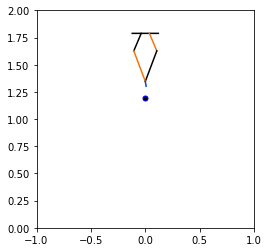

In [27]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
    #plot body
    body_xb = m.X[i,'xb'].value - 0.5*m.length['body']*cos(m.X[i,'thb'].value)
    body_yb = m.X[i,'yb'].value - 0.5*m.length['body']*sin(m.X[i,'thb'].value)
    body_xf = m.X[i,'xb'].value + 0.5*m.length['body']*cos(m.X[i,'thb'].value)
    body_yf = m.X[i,'yb'].value + 0.5*m.length['body']*sin(m.X[i,'thb'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
        
    #plot upper right
    th_RU = m.X[i,'thb'].value + m.X[i,'thurl'].value
    leg1_xtr = m.X[i,'xb'].value + 0.5*m.LL.value*cos(m.X[i,'thb'].value)
    leg1_ytr = m.X[i,'yb'].value + 0.5*m.LL.value*sin(m.X[i,'thb'].value)
    leg1_xbr = m.X[i,'xb'].value + 0.5*m.LL.value*cos(m.X[i,'thb'].value) - m.length['url']*cos(th_RU)
    leg1_ybr = m.X[i,'yb'].value + 0.5*m.LL.value*sin(m.X[i,'thb'].value) - m.length['url']*sin(th_RU)
    ax.plot([leg1_xtr,leg1_xbr],[leg1_ytr,leg1_ybr],color='xkcd:orange')
    
    #plot lower right
    th_RL =  m.X[i,'thlrl'].value - (np.pi-th_RU)
    leg2_xtr = leg1_xbr
    leg2_ytr = leg1_ybr
    leg2_xbr = leg1_xbr - m.length['lrl']*cos(th_RL)
    leg2_ybr = leg1_ybr - m.length['lrl']*sin(th_RL)
    ax.plot([leg2_xtr,leg2_xbr],[leg2_ytr,leg2_ybr],color='xkcd:black')
    
    #plot upper right
    th_LU = m.X[i,'thb'].value + m.X[i,'thull'].value
    leg1_xtl = m.X[i,'xb'].value - 0.5*m.LL.value*cos(m.X[i,'thb'].value)
    leg1_ytl = m.X[i,'yb'].value - 0.5*m.LL.value*sin(m.X[i,'thb'].value)
    leg1_xbl = m.X[i,'xb'].value - 0.5*m.LL.value*cos(m.X[i,'thb'].value) - m.length['ull']*cos(th_LU)
    leg1_ybl = m.X[i,'yb'].value - 0.5*m.LL.value*sin(m.X[i,'thb'].value) - m.length['ull']*sin(th_LU)
    ax.plot([leg1_xtl,leg1_xbl],[leg1_ytl,leg1_ybl],color='xkcd:black')

    #plot lower right
    th_LL =  m.X[i,'thlll'].value - (np.pi-th_LU)
    leg2_xtl = leg1_xbl
    leg2_ytl = leg1_ybl
    leg2_xbl = leg1_xbl - m.length['lll']*cos(th_LL)
    leg2_ybl = leg1_ybl - m.length['lll']*sin(th_LL)
    ax.plot([leg2_xtl,leg2_xbl],[leg2_ytl,leg2_ybl],color='xkcd:orange')
    
    #plot foot
    mu = 150*(np.pi/180) 
    foot_xt = leg2_xbr
    foot_yt = leg2_ybr
    foot_xb = foot_xt + m.length_foot*cos(mu-th_RL)
    foot_yb = foot_yt - m.length_foot*sin(mu-th_RL)
    ax.plot([foot_xt,foot_xb],[foot_yt,foot_yb],color='xkcd:blue')
    
    ax.plot(m.boom_position[i,'X'].value, m.boom_position[i,'Y'].value, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="black")
    
    ax.plot([-100,100],[-10,-10]) # plot the ground
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 20,repeat=False)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

# f = r"/home/zubair/Trajectory-Optimization-Pyomo-/Monopod/Redo/with_boom/{0}_new.mp4".format(test) 
# writervideo = ani.FFMpegWriter(fps=20) 
# animate.save(f, writer=writervideo)  


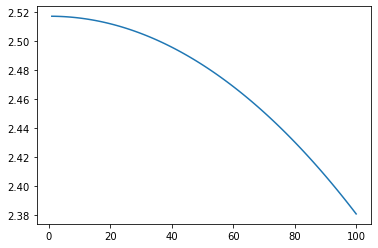

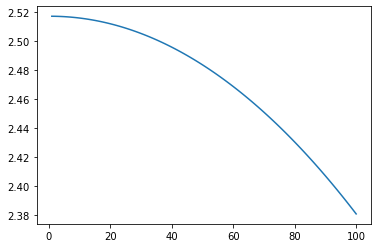

In [29]:
constact_comp = []
left_knee = []
right_knee = []


for n in N_time:
    #constact_comp.append(GRF_Y_values[n]*foot_position_values[n])
    left_knee.append(2*np.pi - m.X[n,'thlll'].value)
    right_knee.append(m.X[n,'thlrl'].value)
    
plt.plot(N_time,left_knee)
plt.figure()
plt.plot(N_time,right_knee)